In [0]:
!pip install SimpleITK

     |████████████████████████████████| 42.5MB 72kB/s 


In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas
import SimpleITK as sitk

In [0]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Mounted at /content/drive


In [0]:
def padVolumeToMakeItMultipleOf(v, multipleOf=None, mode='minimum'):
    if not multipleOf:
        multipleOf = [3,3,3]

    padding = ((0, 0 if v.shape[0] % multipleOf[0] == 0 else multipleOf[0] - (v.shape[0] % multipleOf[0])),
               (0, 0 if v.shape[1] % multipleOf[1] == 0 else multipleOf[1] - (v.shape[1] % multipleOf[1])),
               (0, 0 if v.shape[2] % multipleOf[2] == 0 else multipleOf[2] - (v.shape[2] % multipleOf[2])))

    return np.pad(v, padding, mode)

def diff_sitk(A, B):
    """ Perform A-B with A and B SimpleITK images.
    """
    A = sitk.Cast(A, sitk.sitkInt8)
    B = sitk.Cast(B, sitk.sitkInt8)
    result = sitk.Cast(sitk.And(sitk.Not(A), B), sitk.sitkFloat32)
    result.SetOrigin(A.GetOrigin())
    result.SetDirection(A.GetDirection())
    result.SetSpacing(A.GetSpacing())
    return result

def erode_image_sitk(image, times=1, kernel_radius=1, foreground_value=1):
    image = sitk.Cast(image, sitk.sitkInt16)
    kernel = sitk.sitkCross
    image = sitk.BinaryMorphologicalOpening(image, kernel_radius, kernel)

    image = sitk.Cast(image, sitk.sitkFloat32)

    return image

def retainLargestConnectedComponent(image):
    """
       Retains only the largest connected component of a binary image, and returns it.
   """
    image = sitk.Cast(image, sitk.sitkUInt32)

    connectedComponentFilter = sitk.ConnectedComponentImageFilter()
    objects = connectedComponentFilter.Execute(image)

    # If there is more than one connected component
    if connectedComponentFilter.GetObjectCount() > 1:
        objectsData = sitk.GetArrayFromImage(objects)

        # Detect the largest connected component
        maxLabel = 1
        maxLabelCount = 0
        for i in range(1, connectedComponentFilter.GetObjectCount() + 1):
            componentData = objectsData[objectsData == i]

            if len(componentData.flatten()) > maxLabelCount:
                maxLabel = i
                maxLabelCount = len(componentData.flatten())

        # Remove all the values, exept the ones for the largest connected component

        dataAux = np.zeros(objectsData.shape, dtype=np.uint8)

        # Fuse the labels

        dataAux[objectsData == maxLabel] = 1

        # Save edited data
        output = sitk.GetImageFromArray(dataAux)
        output.SetSpacing(image.GetSpacing())
        output.SetOrigin(image.GetOrigin())
        output.SetDirection(image.GetDirection())
    else:
        output = image

    return output

In [0]:
data_path = '/content/drive/My Drive/prep_heads'
train_file = 'files_train.csv'
test_file = 'files_test.csv'
img_folder = '/content/drive/My Drive/prep_heads/imgs/'

train_path = os.path.join(data_path, train_file)
test_path = os.path.join(data_path, test_file)
df_train = img_folder + pandas.read_csv(train_path)  # add path to each filename
df_test = img_folder + pandas.read_csv(test_path)  

print("Training images: ", df_train.shape[0])
print("Test images: ", df_test.shape[0])

# Load SimpleITK images
sitk_train = [sitk.ReadImage(df_train.iloc[i, 0]) for i in range(df_train.shape[0])]
sitk_test = [sitk.ReadImage(df_test.iloc[i, 0]) for i in range(df_test.shape[0])]

# Convert them to numpy
np_train = np.array([padVolumeToMakeItMultipleOf(sitk.GetArrayFromImage(sitk_train[i]), [16, 16, 16]) for i in range(df_train.shape[0])])
np_test = np.array([padVolumeToMakeItMultipleOf(sitk.GetArrayFromImage(sitk_test[i]), [16, 16, 16]) for i in range(df_test.shape[0])])

im_dims = np_train.shape[1:]  # 80, 112, 112

# I must reshape because scikit-learn only allows 2D (index, data).
np_train_r = [np.reshape(np_train[i], (np.prod(im_dims))) for i in range(df_train.shape[0])]
np_test_r = [np.reshape(np_test[i], (np.prod(im_dims))) for i in range(df_test.shape[0])]


Training images:  42
Test images:  7
Training images:  42
Test images:  7


Amount of components:  42


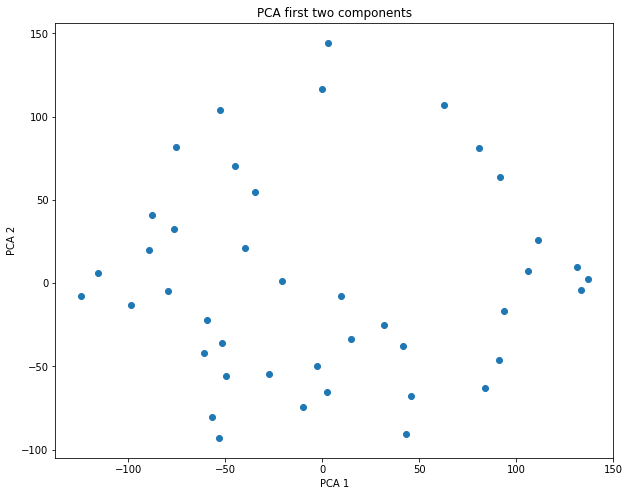

Amount of components:  42


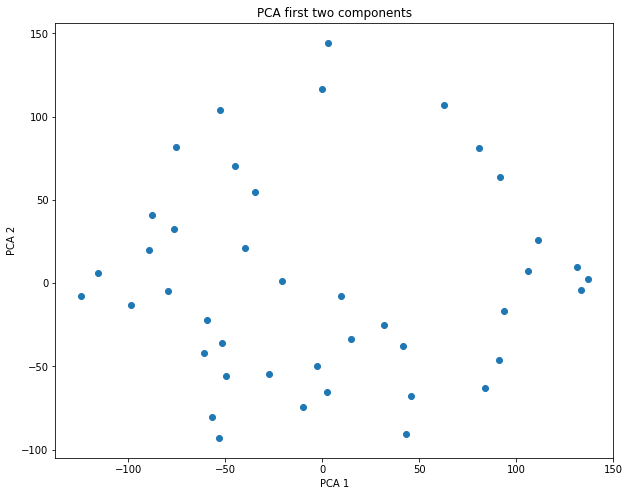

In [0]:
pca = PCA()
pca.fit(np_train_r)
X_pca = pca.transform(np_train_r)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
scatter = ax.scatter(X_pca[:, 0],
                     X_pca[:, 1])

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("PCA first two components")

print("Amount of components: ", pca.n_components_)

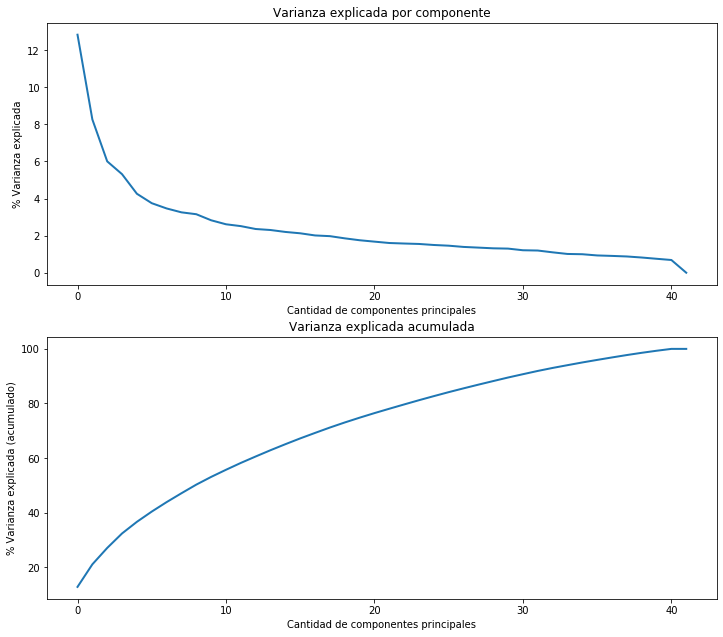

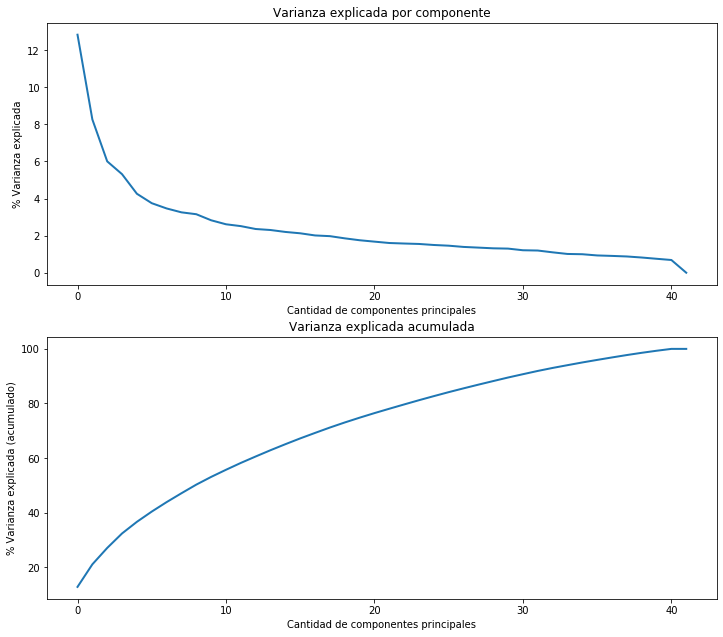

In [0]:
ratio_varianzas = pca.explained_variance_ratio_

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
plt.subplots_adjust(top=4, bottom=3)

ax1.plot(100 * ratio_varianzas, linewidth=2)
ax1.set_xlabel('Cantidad de componentes principales')
ax1.set_ylabel('% Varianza explicada')
ax1.set_title("Varianza explicada por componente")

ax2.plot(100 * np.cumsum(ratio_varianzas), linewidth=2)
ax2.set_xlabel('Cantidad de componentes principales')
ax2.set_ylabel('% Varianza explicada (acumulado)')
ax2.set_title("Varianza explicada acumulada")

plt.show()

In [0]:
n_componentes = 40

pca = PCA(n_components=n_componentes)
pca.fit(np_train_r)

print("Ratio de varianza explicada con {} componentes: {:.2f}%".format(n_componentes, 
                                                                       100 * np.sum(pca.explained_variance_ratio_)))

Ratio de varianza explicada con 40 componentes: 99.31%
Ratio de varianza explicada con 40 componentes: 99.31%


Text(0.5, 1.0, 'Average skull with 40 components')

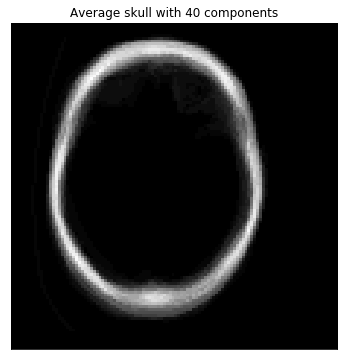

Text(0.5, 1.0, 'Average skull with 40 components')

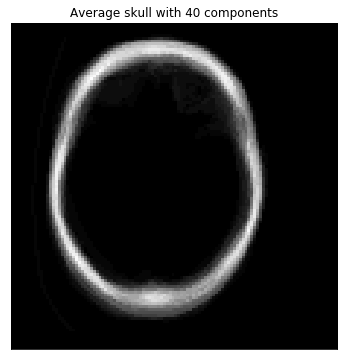

In [0]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(pca.mean_.reshape((80, 112, 112))[40, :, :], cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average skull with {} components'.format(n_componentes))

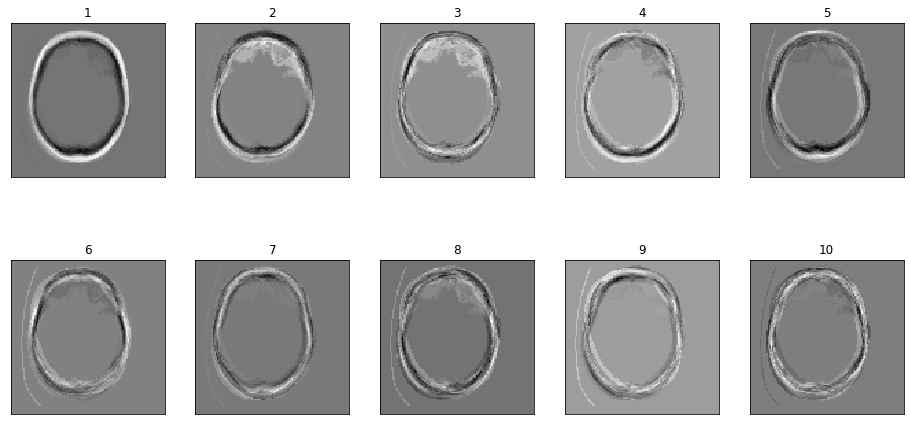

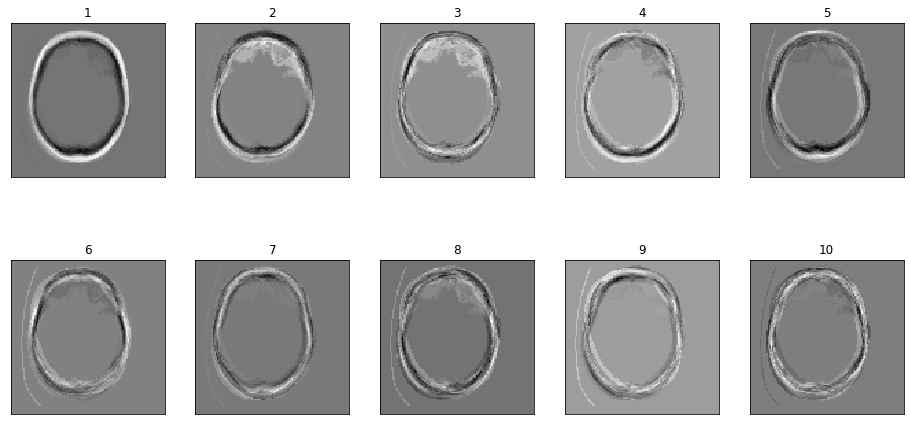

In [0]:
eigen_skulls = pca.components_.reshape((pca.n_components_, 80, 112, 112))

cols = 5
rows = int(10/cols)
fig, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(16,8))
axarr = axarr.flatten()
for i in range(10):
    axarr[i].imshow(eigen_skulls[i][40, :, :], cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("{}".format(i + 1))


In [0]:
Y_pca = pca.transform(np_test_r)  # Get coefficients in th projected space
pred_pca = pca.inverse_transform(Y_pca)  # Go back to the original space from the projected one

pred_pca = pred_pca.reshape((pred_pca.shape[0], im_dims[0], im_dims[1], im_dims[2]))

for i, pred in enumerate(pred_pca):
  sitk_pred = sitk.GetImageFromArray(pred) > 0.5
  sitk_pred.SetOrigin(sitk_test[i].GetOrigin())
  sitk_pred.SetDirection(sitk_test[i].GetDirection())
  sitk_pred.SetSpacing(sitk_test[i].GetSpacing())

  path, name = os.path.split(df_test.iloc[i, 0])
  path = os.path.join(path, 'pred_PCA')
  if not os.path.exists(path):
    os.makedirs(path)

  name_out = name.replace(".nii.gz", "_pca.nii.gz".format(i))
  sitk.WriteImage(sitk_pred, os.path.join(path, name_out))  # Save PCA prediction

  sitk_input_img = sitk.GetImageFromArray(np_test[i])  # Input image
  sitk_input_img.SetOrigin(sitk_test[i].GetOrigin())
  sitk_input_img.SetDirection(sitk_test[i].GetDirection())
  sitk_input_img.SetSpacing(sitk_test[i].GetSpacing())

  sitk_diff = diff_sitk(sitk_input_img, sitk_pred)  # Difference
  sitk_diff_eroded = erode_image_sitk(sitk_diff)  # Erode
  sitk_diff_cc = retainLargestConnectedComponent(sitk_diff)

  sitk.WriteImage(sitk_diff, os.path.join(path, name_out.replace('pca', 'pca_diff')))  # Save diff
  sitk.WriteImage(sitk_diff_eroded, os.path.join(path, name_out.replace('pca', 'pca_diff_eroded')))  # Save eroded
  sitk.WriteImage(sitk_diff_cc, os.path.join(path, name_out.replace('pca', 'pca_diff_cc')))  # Save eroded

  print("  Saved: {}.".format(name_out))


  Saved: 1002_20215_3_image_pca.nii.gz.
  Saved: 1019_7515_image_pca.nii.gz.
  Saved: 1040_14515_image_pca.nii.gz.
  Saved: 1050_8615_image_pca.nii.gz.
  Saved: 1060_13715_image_pca.nii.gz.
  Saved: 1080_23915_image_pca.nii.gz.
  Saved: 1111_22216_2_image_pca.nii.gz.
  Saved: 1002_20215_3_image_pca.nii.gz.
  Saved: 1019_7515_image_pca.nii.gz.
  Saved: 1040_14515_image_pca.nii.gz.
  Saved: 1050_8615_image_pca.nii.gz.
  Saved: 1060_13715_image_pca.nii.gz.
  Saved: 1080_23915_image_pca.nii.gz.
  Saved: 1111_22216_2_image_pca.nii.gz.
